<a href="https://colab.research.google.com/github/Dharamchandpatle/Refinery-AIML/blob/main/AnamolyDetectionIOCL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:

# Parameters
rows = 100000  # large dataset
np.random.seed(42)

dates = pd.date_range(start="2022-01-01", periods=rows, freq="H")
units = ["CDU", "VDU", "DCU", "NCU", "Hydrocracker"]

data = {
    "date": np.random.choice(dates, rows),
    "unit_name": np.random.choice(units, rows),
    "electricity_kwh": np.random.normal(950, 120, rows).clip(400, 1600),
    "steam_usage": np.random.normal(500, 80, rows).clip(200, 900),
    "fuel_usage": np.random.normal(300, 60, rows).clip(100, 700),
    "production_tons": np.random.normal(120, 25, rows).clip(40, 200),
}

df = pd.DataFrame(data)

/tmp/ipython-input-2208272586.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start="2022-01-01", periods=rows, freq="H")


In [3]:

# Calculate SEC
df["SEC"] = (df["electricity_kwh"] + df["steam_usage"] + df["fuel_usage"]) / df["production_tons"]



In [4]:

# Inject anomalies (5%)
anomaly_indices = np.random.choice(df.index, size=int(0.05 * rows), replace=False)
df.loc[anomaly_indices, "electricity_kwh"] *= np.random.uniform(1.4, 1.8)
df.loc[anomaly_indices, "SEC"] *= np.random.uniform(1.3, 1.7)

In [6]:
# Save dataset
file_path = "/content/refinery_energy_large_dataset.csv"
df.to_csv(file_path, index=False)
file_path

'/content/refinery_energy_large_dataset.csv'

In [7]:
df.head()


,date,unit_name,electricity_kwh,steam_usage,fuel_usage,production_tons,SEC
0,2023-10-21 03:00:00,Hydrocracker,876.896024,451.883508,315.944364,129.774212,12.673734
1,2022-02-05 20:00:00,CDU,892.363227,583.108650,366.385274,151.946967,12.121711
2,2030-10-06 20:00:00,DCU,1038.607058,554.011159,157.918743,136.168087,12.855707
3,2028-04-05 22:00:00,CDU,808.311888,680.183209,304.637560,138.340267,12.961755
4,2022-09-19 01:00:00,CDU,997.376810,490.170735,337.180859,141.055837,12.936213


In [8]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             100000 non-null  datetime64[ns]
 1   unit_name        100000 non-null  object        
 2   electricity_kwh  100000 non-null  float64       
 3   steam_usage      100000 non-null  float64       
 4   fuel_usage       100000 non-null  float64       
 5   production_tons  100000 non-null  float64       
 6   SEC              100000 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 5.3+ MB


,date,electricity_kwh,steam_usage,fuel_usage,production_tons,SEC
count,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2027-09-12 14:14:58.668000,972.437356,499.851132,300.129255,119.871217,15.846840
min,2022-01-01 01:00:00,415.212862,200.000000,100.000000,40.000000,6.500047
25%,2024-10-23 03:30:00,874.636672,445.939366,259.409521,103.059587,12.742459
50%,2027-09-14 16:30:00,958.248170,499.721193,300.145832,119.938715,14.806698
75%,2030-07-27 00:45:00,1046.315425,553.608806,340.799157,136.807303,17.695516
max,2033-05-29 13:00:00,2002.239589,848.946410,590.107246,200.000000,79.222977
std,NaN,155.714613,79.996411,60.307704,24.965763,4.754760


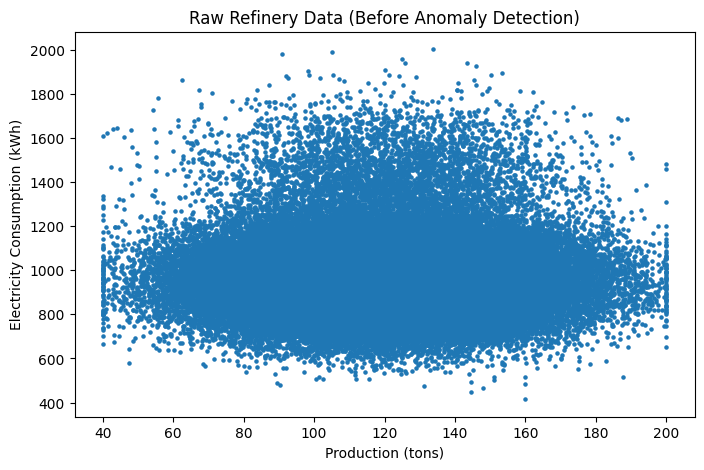

In [17]:
# Visualize RAW DATA
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(df["production_tons"], df["electricity_kwh"], s=5)
plt.xlabel("Production (tons)")
plt.ylabel("Electricity Consumption (kWh)")
plt.title("Raw Refinery Data (Before Anomaly Detection)")
plt.show()


In [10]:
# Select Features for Anomaly Detection

from sklearn.ensemble import IsolationForest

features = [
    "electricity_kwh",
    "steam_usage",
    "fuel_usage",
    "production_tons",
    "SEC"
]

X = df[features]


In [18]:
# Train Isolation Forest Model() ML Brain )
from sklearn.ensemble import IsolationForest

features = [
    "electricity_kwh",
    "steam_usage",
    "fuel_usage",
    "production_tons",
    "SEC"
]

X = df[features]

model = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)

model.fit(X)



IsolationForest(contamination=0.05, random_state=42)

In [19]:
# Predict Anomalies (Core Output)
df["prediction"] = model.predict(X)
df["anomaly"] = df["prediction"].apply(lambda x: 1 if x == -1 else 0)


In [14]:
df["anomaly_flag"] = df["anomaly"].apply(lambda x: 1 if x == -1 else 0)


In [21]:
# check count
df["anomaly_flag"].value_counts()


,count
anomaly_flag,
0,95000
1,5000


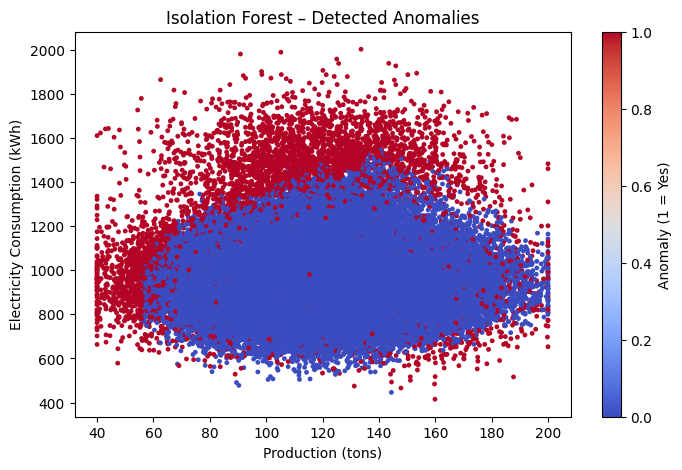

In [22]:
# Visualize DETECTED ANOMALIES#

plt.figure(figsize=(8,5))
plt.scatter(
    df["production_tons"],
    df["electricity_kwh"],
    c=df["anomaly"],
    cmap="coolwarm",
    s=6
)
plt.xlabel("Production (tons)")
plt.ylabel("Electricity Consumption (kWh)")
plt.title("Isolation Forest – Detected Anomalies")
plt.colorbar(label="Anomaly (1 = Yes)")
plt.show()


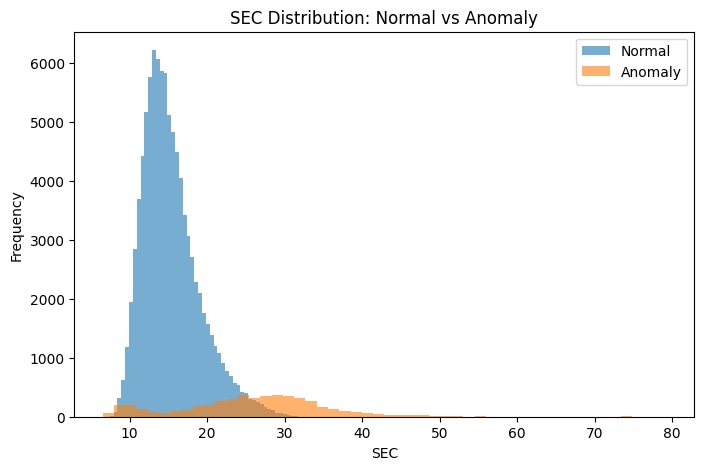

In [24]:
# Compare NORMAL vs ANOMALY DISTRIBUTION
plt.figure(figsize=(8,5))
plt.hist(df[df["anomaly"]==0]["SEC"], bins=50, alpha=0.6, label="Normal")
plt.hist(df[df["anomaly"]==1]["SEC"], bins=50, alpha=0.6, label="Anomaly")
plt.xlabel("SEC")
plt.ylabel("Frequency")
plt.title("SEC Distribution: Normal vs Anomaly")
plt.legend()
plt.show()


In [25]:
# View ACTUAL ANOMALY RECORDS (Data Output)
df[df["anomaly"] == 1].head(10)


,date,unit_name,electricity_kwh,steam_usage,fuel_usage,production_tons,SEC,anomaly,anomaly_flag,prediction
30,2028-09-30 14:00:00,VDU,1450.688601,669.067312,271.321248,119.675999,26.817049,1,1,-1
37,2025-08-07 15:00:00,CDU,1481.099082,604.438213,302.817301,69.553172,45.848613,1,1,-1
128,2029-03-23 23:00:00,VDU,1429.136644,411.457285,190.076555,103.535688,25.328594,1,1,-1
144,2024-09-02 19:00:00,Hydrocracker,1497.763154,523.948807,253.993964,75.471039,39.660380,1,1,-1
187,2028-08-15 21:00:00,Hydrocracker,1390.111929,526.020614,373.344972,108.402417,28.342821,1,1,-1
192,2033-02-14 16:00:00,DCU,1547.052656,480.664598,223.343309,130.989074,22.341530,1,1,-1
205,2026-06-28 17:00:00,CDU,1257.835241,441.255748,436.633845,132.520761,21.781306,1,1,-1
211,2024-09-13 00:00:00,CDU,1546.374959,511.172092,330.272881,106.751663,29.543835,1,1,-1
223,2031-12-08 20:00:00,VDU,1064.062153,617.689881,362.430920,190.998746,10.702599,1,1,-1
227,2029-04-09 14:00:00,NCU,1578.624147,425.043367,266.963660,137.370556,21.419813,1,1,-1


In [26]:
# 2. Handle missing values
df.fillna(df.median(), inplace=True)

TypeError: Cannot convert [['Hydrocracker' 'CDU' 'DCU' ... 'CDU' 'DCU' 'DCU']] to numeric